In [1]:
from sklearn import metrics
import pandas as pd
import numpy as np
import math
import random


In [2]:
def build_y_true(row):
    tps = row['true_positives']
    pop = row['population']
    return np.array([1] * tps + [0] * (pop - tps))

def gen_prediction(tpr, fpr, y_true, info=False):
    y_pred = []
    tpr_cuttoff = math.floor(tpr * len(list(filter(lambda x: x, y_true))))
    selected_tp = 0
    info and print(f"Going to select {tpr_cuttoff} ({tpr} of {len(y_true)}) true samples")
    fpr_cuttoff = math.floor(fpr * len(list(filter(lambda x: not x, y_true))))
    selected_fp = 0
    info and print(f"Going to select {fpr_cuttoff} ({fpr} of {len(y_true)}) false samples")
    for i, y in enumerate(y_true):
        if y == 1:
            if selected_tp < tpr_cuttoff:
                y_pred.append(1)
                selected_tp += 1
            else:
                y_pred.append(0)
        if y == 0:
            if selected_fp < fpr_cuttoff:
                selected_fp += 1
                y_pred.append(1)
            else:
                y_pred.append(0)
    return y_pred

In [3]:
def apply_predictor_to_grid(generate_experiment, metrics, y_true, s=20):
    tpr_range = list(map(lambda x: x and x/s, range(1, s)))
    fpr_range = list(map(lambda x: x and x/s, range(1, s)))
    print()
    arr = []
    for tpr in tpr_range:
        row = []
        for fpr in fpr_range:
            y_pred, y_true = generate_experiment(tpr, fpr)
            ms = [metric(y_pred, y_true) for _, metric in metrics]
            #row.append((tpr, fpr, ms, y_pred, y_true))
            arr.append((tpr, fpr, *ms))
        #arr.append(row)
    return arr

metrics_to_track = [
        ('precision', lambda y_pred, y_true: metrics.precision_score(y_true, y_pred)),
        ('weighted precision', lambda y_pred, y_true: metrics.precision_score(y_true, y_pred, average='weighted')),
        ('average_precision', lambda y_pred, y_true: metrics.average_precision_score(y_true, y_pred)),
        ('recall', lambda y_pred, y_true: metrics.recall_score(y_true, y_pred, zero_division=0)),
        ('weighted recall', lambda y_pred, y_true: metrics.recall_score(y_true, y_pred, average='weighted', zero_division=0)),
        ('f1 score', lambda y_pred, y_true: metrics.f1_score(y_true, y_pred)),
        ('weighted f1 score', lambda y_pred, y_true: metrics.f1_score(y_true, y_pred, average='weighted')),
        ('accuracy', lambda y_pred, y_true: metrics.accuracy_score(y_true, y_pred)),
]

def build_grid(y_true):
    generate_experiment = lambda tpr, fpr: (gen_prediction(tpr, fpr, y_true), y_true)
    return apply_predictor_to_grid(generate_experiment, metrics_to_track, y_true)


metrics_data = np.array(build_grid([0] + [1] * 100))
#metrics_data

In [4]:
metrics_data_pdf = pd.DataFrame(metrics_data, columns = ['tpr', 'fpr'] + [metric_name for metric_name, _ in metrics_to_track])
metrics_data_pdf

,tpr,fpr,precision,weighted precision,average_precision,recall,weighted recall,f1 score,weighted f1 score,accuracy
0,0.05,0.05,1.0,0.990202,0.990594,0.05,0.059406,0.095238,0.094499,0.059406
1,0.05,0.10,1.0,0.990202,0.990594,0.05,0.059406,0.095238,0.094499,0.059406
2,0.05,0.15,1.0,0.990202,0.990594,0.05,0.059406,0.095238,0.094499,0.059406
3,0.05,0.20,1.0,0.990202,0.990594,0.05,0.059406,0.095238,0.094499,0.059406
4,0.05,0.25,1.0,0.990202,0.990594,0.05,0.059406,0.095238,0.094499,0.059406
...,...,...,...,...,...,...,...,...,...,...
356,0.95,0.75,1.0,0.991749,0.999505,0.95,0.950495,0.974359,0.967541,0.950495
357,0.95,0.80,1.0,0.991749,0.999505,0.95,0.950495,0.974359,0.967541,0.950495
358,0.95,0.85,1.0,0.991749,0.999505,0.95,0.950495,0.974359,0.967541,0.950495
359,0.95,0.90,1.0,0.991749,0.999505,0.95,0.950495,0.974359,0.967541,0.950495


In [5]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def plot_metric_chart(ax, metric_target, population_size, metrics_data_pdf, rotation=None):
    surf = ax.plot_trisurf(metrics_data_pdf['tpr'], metrics_data_pdf['fpr'], metrics_data_pdf[metric_target], cmap=plt.cm.jet, linewidth=0.2)
    if rotation:
        ax.view_init(*rotation)
    ax.set_xlabel('tpr')
    ax.set_ylabel('fpr')
    ax.set_title(f"{metric_target} @ {population_size}")


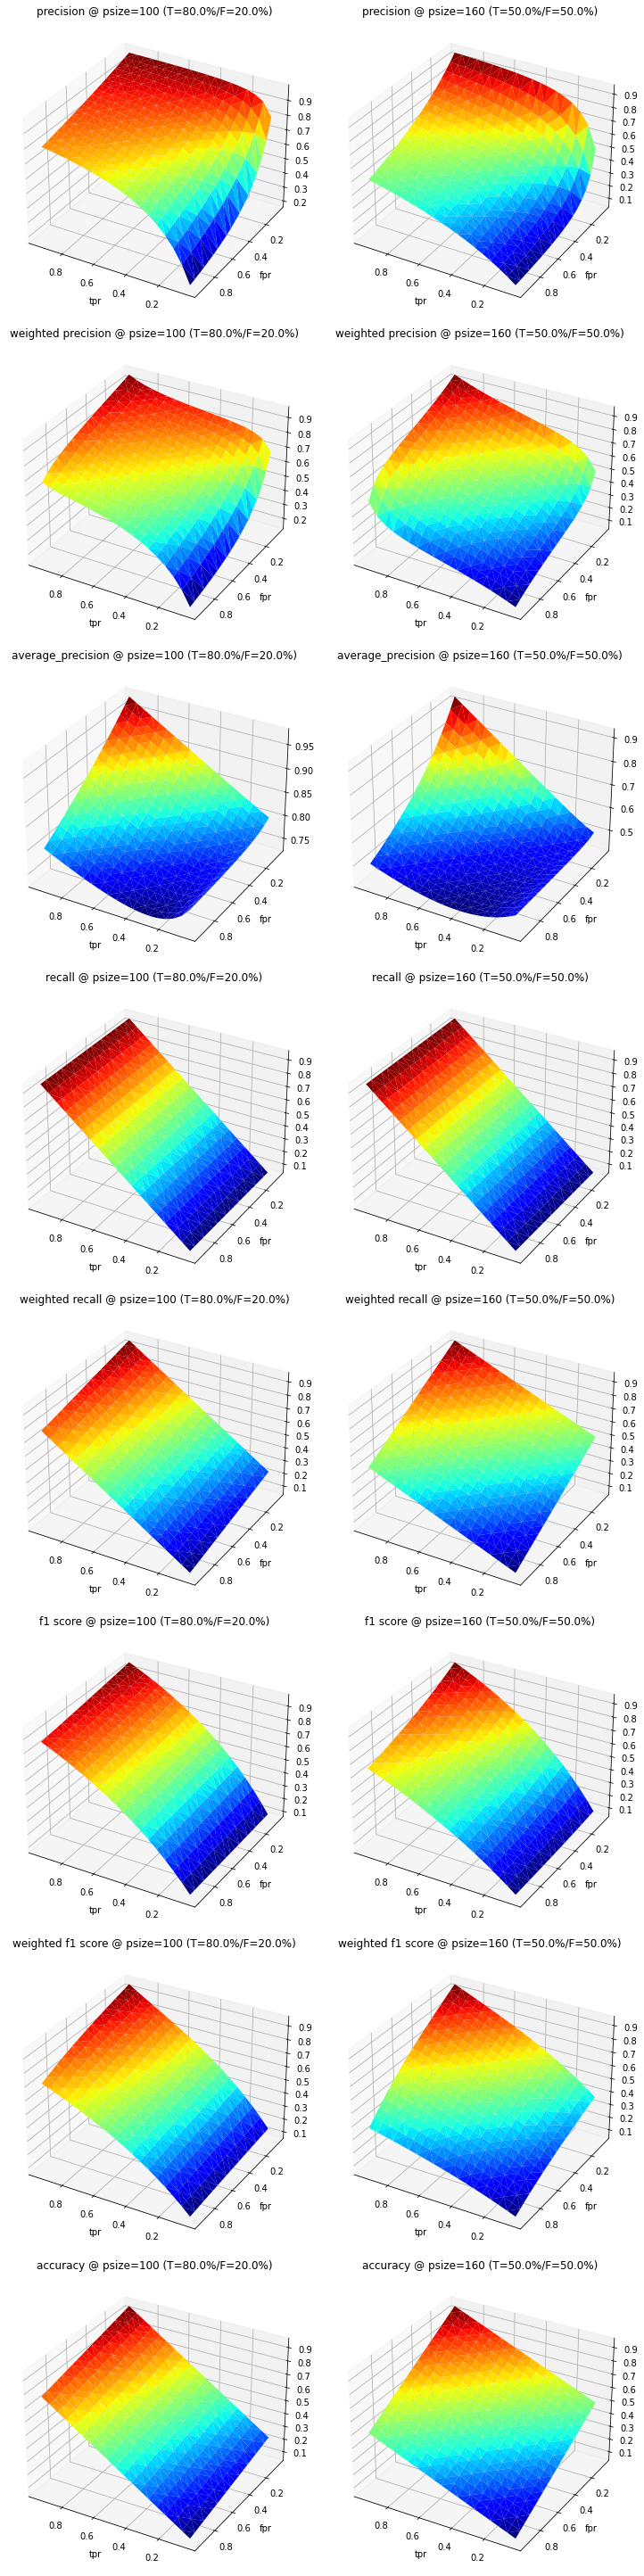

In [6]:
#poplation_sizes = [10, 50, 100, 1000, 10000]
poplation_sizes = [100, 160, 160*2, 1000, 10000]
poplation_sizes = [100, 160]
true_positives = 80
fig = plt.figure(constrained_layout=True, figsize=(5*len(poplation_sizes), 5*len(metrics_to_track)))
spec = gridspec.GridSpec(nrows=len(metrics_to_track), ncols=len(poplation_sizes), figure=fig)
for i, population_size in enumerate(poplation_sizes):
    tps = true_positives
    pop = population_size
    y_true = [1] * tps + [0] * (pop - tps)
    random.shuffle(y_true)
    metrics_data = np.array(build_grid(y_true))
    metrics_data_pdf = pd.DataFrame(metrics_data, columns = ['tpr', 'fpr'] + [metric_name for metric_name, _ in metrics_to_track])
    for j, (metric_name, _) in enumerate(metrics_to_track):
        ax = fig.add_subplot(spec[j, i], projection='3d')
        rotation = (30, 120)
        plot_metric_chart(ax, metric_name, f"psize={population_size} (T={100*round(true_positives/population_size,2)}%/F={100 - 100*round(true_positives/population_size,2)}%)", metrics_data_pdf, rotation=rotation)

filename='metrics-at-different-population-sizes-trues-are-80.png'
fig.set_rasterized(True)
fig.savefig(filename, dpi=96)

In [ ]:
#poplation_sizes = [10, 50, 100, 1000, 10000]
poplation_sizes = [100, 160, 160*2, 1000, 10000]
#poplation_sizes = [100, 160]
true_positives = 80
run_id = random.randint(1, 2**64)
print(f"Building format: ./PNG/ANIMATION/plots_step_{run_id}_*.png")
for angle in range(70,360,2):
    rotation = (30, angle)
    fig = plt.figure(constrained_layout=True, figsize=(5*len(poplation_sizes), 5*len(metrics_to_track)))
    spec = gridspec.GridSpec(nrows=len(metrics_to_track), ncols=len(poplation_sizes), figure=fig)
    for i, population_size in enumerate(poplation_sizes):
        tps = true_positives
        pop = population_size
        y_true = [1] * tps + [0] * (pop - tps)
        random.shuffle(y_true)
        metrics_data = np.array(build_grid(y_true))
        metrics_data_pdf = pd.DataFrame(metrics_data, columns = ['tpr', 'fpr'] + [metric_name for metric_name, _ in metrics_to_track])
        for j, (metric_name, _) in enumerate(metrics_to_track):
            ax = fig.add_subplot(spec[j, i], projection='3d') 
            plot_metric_chart(ax, metric_name, f"psize={population_size} (T={100*round(true_positives/population_size,2)}%/F={100 - 100*round(true_positives/population_size,2)}%)", metrics_data_pdf, rotation=rotation)
    filename=f'PNG/ANIMATION/plots_step_{run_id}_{angle}.png'
    #fig.set_rasterized(True)
    fig.savefig(filename, dpi=96)
    plt.close(fig=fig)

Building format: PNG/ANIMATION/plots_step_6383097288492282222_*.png











































































































































































































































































































































































In [ ]:
#convert -delay 50 ./PNG/ANIMATION/plots_step*.png animated_plot.gif